In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
RUN_ID = "run_2026_01_10_seresnet_ls"
model_save_name = "seresnet_ls"

In [4]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [ ]:
BATCH_SIZE = 2048
num_workers = 0

TRAIN_PATH = Path("./dataset_planes/plane_train.npz")
VAL_PATH = Path("./dataset_planes/plane_val.npz")
TEST_PATH = Path("./dataset_planes/plane_test.npz") 

train_dataloader = DataLoader(dataset=NPZChessDataset(TRAIN_PATH), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset(VAL_PATH), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset(TEST_PATH), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [ ]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.044524204730987546


In [ ]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 19, 8, 8]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [ ]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        # bias = False because BatchNorm effectively cancels any bias term
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =  nn.BatchNorm2d(channels)
        self.bn2 =  nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        self.se = SEBlock(channels, reduction=8)

    # x is shape [19,8,8]
    def forward(self, x):
        identity = x 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x) # add if overfitting
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        x += identity
        x = self.relu(x)
        # x = self.dropout(x) # add if overfitting
        return x

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Squeeze: Global Average Pooling (turns Cx8x8 tensor into Cx1x1 tensor (not flattened))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Excitation: A tiny fully connected network to learn channel weights
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction), # Compress
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels), # Expand
            nn.Sigmoid() # Output a (0.0 to 1.0) for importance
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Calculate importance scores
        y = self.avg_pool(x).view(batch, channels)
        y = self.mlp(y).view(batch, channels, 1, 1)
        
        # Scale the original input by these scores
        return x * y.expand_as(x)

class SEResNet(nn.Module):
    def __init__(self, in_channels=19, channels=64, num_blocks=10, num_classes=7):
        super().__init__()
        # 96
        # Initial convolution on board
        self.initialconv = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

        # Main residual block
        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualBlock(channels))
        self.res_tower = nn.Sequential(*blocks)

        # Classifier
        self.flatten_dim = channels * 8 * 8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)      
        )

    def forward(self, x):
        x = self.initialconv(x)
        x = self.res_tower(x)
        x = self.classifier(x)
        return x

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [ ]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [ ]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   device=device,
                   patience: int = 7):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    patience_counter = 0 
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch {epoch}: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [ ]:
from torchinfo import summary

model = SEResNet(in_channels=19, 
                 channels=64, 
                 num_blocks=10, 
                 num_classes=7).to(device)

summary(model, input_size=(BATCH_SIZE, 19, 8, 8))

Layer (type:depth-idx)                        Output Shape              Param #
SEResNet                                      [2048, 7]                 --
├─Sequential: 1-1                             [2048, 64, 8, 8]          --
│    └─Conv2d: 2-1                            [2048, 64, 8, 8]          10,944
│    └─BatchNorm2d: 2-2                       [2048, 64, 8, 8]          128
│    └─ReLU: 2-3                              [2048, 64, 8, 8]          --
├─Sequential: 1-2                             [2048, 64, 8, 8]          --
│    └─ResidualBlock: 2-4                     [2048, 64, 8, 8]          --
│    │    └─Conv2d: 3-1                       [2048, 64, 8, 8]          36,864
│    │    └─BatchNorm2d: 3-2                  [2048, 64, 8, 8]          128
│    │    └─ReLU: 3-3                         [2048, 64, 8, 8]          --
│    │    └─Conv2d: 3-4                       [2048, 64, 8, 8]          36,864
│    │    └─BatchNorm2d: 3-5                  [2048, 64, 8, 8]          128
│    

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=1e-2)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        device=device)

Starting Training: seresnet


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: New Best Val Loss: 1.1865 (Saved)


  1%|          | 1/100 [06:06<10:03:56, 366.03s/it]

Epoch: 0 | Train Loss: 1.2743 | Val Loss: 1.1865 | Val Acc: 0.5270


  2%|▏         | 2/100 [11:44<9:31:12, 349.72s/it] 

Epoch 1: New Best Val Loss: 1.0248 (Saved)
Epoch: 1 | Train Loss: 1.0206 | Val Loss: 1.0248 | Val Acc: 0.5806


  3%|▎         | 3/100 [17:27<9:20:37, 346.78s/it]

Epoch 2: New Best Val Loss: 0.9614 (Saved)
Epoch: 2 | Train Loss: 0.9276 | Val Loss: 0.9614 | Val Acc: 0.6102


  4%|▍         | 4/100 [23:34<9:27:38, 354.78s/it]

Epoch 3: No improvement. Patience 1/7
Epoch: 3 | Train Loss: 0.8726 | Val Loss: 0.9998 | Val Acc: 0.5912


  5%|▌         | 5/100 [29:54<9:36:19, 364.00s/it]

Epoch 4: New Best Val Loss: 0.8649 (Saved)
Epoch: 4 | Train Loss: 0.8365 | Val Loss: 0.8649 | Val Acc: 0.6497


  6%|▌         | 6/100 [35:21<9:10:24, 351.32s/it]

Epoch 5: New Best Val Loss: 0.8471 (Saved)
Epoch: 5 | Train Loss: 0.8085 | Val Loss: 0.8471 | Val Acc: 0.6569


  7%|▋         | 7/100 [41:08<9:02:25, 349.96s/it]

Epoch 6: No improvement. Patience 1/7
Epoch: 6 | Train Loss: 0.7874 | Val Loss: 0.8911 | Val Acc: 0.6370


  8%|▊         | 8/100 [47:10<9:02:30, 353.81s/it]

Epoch 7: New Best Val Loss: 0.8372 (Saved)
Epoch: 7 | Train Loss: 0.7694 | Val Loss: 0.8372 | Val Acc: 0.6580


  9%|▉         | 9/100 [53:10<8:59:10, 355.50s/it]

Epoch 8: No improvement. Patience 1/7
Epoch: 8 | Train Loss: 0.7544 | Val Loss: 0.9181 | Val Acc: 0.6286


 10%|█         | 10/100 [59:04<8:52:54, 355.27s/it]

Epoch 9: No improvement. Patience 2/7
Epoch: 9 | Train Loss: 0.7414 | Val Loss: 0.9345 | Val Acc: 0.6246


 11%|█         | 11/100 [1:05:22<8:57:15, 362.19s/it]

Epoch 10: New Best Val Loss: 0.8370 (Saved)
Epoch: 10 | Train Loss: 0.7298 | Val Loss: 0.8370 | Val Acc: 0.6601


 12%|█▏        | 12/100 [1:10:50<8:35:40, 351.60s/it]

Epoch 11: New Best Val Loss: 0.8231 (Saved)
Epoch: 11 | Train Loss: 0.7196 | Val Loss: 0.8231 | Val Acc: 0.6672


 13%|█▎        | 13/100 [1:15:42<8:03:57, 333.76s/it]

Epoch 12: New Best Val Loss: 0.8126 (Saved)
Epoch: 12 | Train Loss: 0.7102 | Val Loss: 0.8126 | Val Acc: 0.6752


 14%|█▍        | 14/100 [1:21:18<7:59:07, 334.27s/it]

Epoch 13: No improvement. Patience 1/7
Epoch: 13 | Train Loss: 0.7026 | Val Loss: 0.8248 | Val Acc: 0.6705


 15%|█▌        | 15/100 [1:27:17<8:04:07, 341.74s/it]

Epoch 14: No improvement. Patience 2/7
Epoch: 14 | Train Loss: 0.6947 | Val Loss: 0.8401 | Val Acc: 0.6642


 16%|█▌        | 16/100 [1:33:09<8:02:59, 345.00s/it]

Epoch 15: No improvement. Patience 3/7
Epoch: 15 | Train Loss: 0.6877 | Val Loss: 0.8451 | Val Acc: 0.6604


 17%|█▋        | 17/100 [1:39:02<8:00:34, 347.41s/it]

Epoch 16: No improvement. Patience 4/7
Epoch: 16 | Train Loss: 0.6813 | Val Loss: 0.8485 | Val Acc: 0.6629


 18%|█▊        | 18/100 [1:44:37<7:49:41, 343.68s/it]

Epoch 17: No improvement. Patience 5/7
Epoch: 17 | Train Loss: 0.6752 | Val Loss: 0.8804 | Val Acc: 0.6507


 19%|█▉        | 19/100 [1:50:04<7:36:57, 338.49s/it]

Epoch 18: No improvement. Patience 6/7
Epoch: 18 | Train Loss: 0.6695 | Val Loss: 0.8875 | Val Acc: 0.6534


 20%|██        | 20/100 [1:55:27<7:25:02, 333.78s/it]

Epoch 19: New Best Val Loss: 0.8075 (Saved)
Epoch: 19 | Train Loss: 0.6044 | Val Loss: 0.8075 | Val Acc: 0.6873


 21%|██        | 21/100 [2:01:07<7:22:04, 335.75s/it]

Epoch 20: No improvement. Patience 1/7
Epoch: 20 | Train Loss: 0.5895 | Val Loss: 0.8165 | Val Acc: 0.6877


 22%|██▏       | 22/100 [2:06:45<7:17:20, 336.42s/it]

Epoch 21: No improvement. Patience 2/7
Epoch: 21 | Train Loss: 0.5828 | Val Loss: 0.8230 | Val Acc: 0.6863


 23%|██▎       | 23/100 [2:11:54<7:01:02, 328.09s/it]

Epoch 22: No improvement. Patience 3/7
Epoch: 22 | Train Loss: 0.5782 | Val Loss: 0.8334 | Val Acc: 0.6852


 24%|██▍       | 24/100 [2:16:47<6:42:31, 317.79s/it]

Epoch 23: No improvement. Patience 4/7
Epoch: 23 | Train Loss: 0.5739 | Val Loss: 0.8400 | Val Acc: 0.6858


 25%|██▌       | 25/100 [2:22:09<6:38:37, 318.90s/it]

Epoch 24: No improvement. Patience 5/7
Epoch: 24 | Train Loss: 0.5705 | Val Loss: 0.8435 | Val Acc: 0.6850


 26%|██▌       | 26/100 [2:27:22<6:31:04, 317.09s/it]

Epoch 25: No improvement. Patience 6/7
Epoch: 25 | Train Loss: 0.5672 | Val Loss: 0.8467 | Val Acc: 0.6847


 26%|██▌       | 26/100 [2:32:27<7:13:54, 351.82s/it]

Epoch 26: No improvement. Patience 7/7
Epoch: 26 | Train Loss: 0.5550 | Val Loss: 0.8523 | Val Acc: 0.6853

[Early Stopping] No improvement for 7 epochs. Stopping.

Loaded best model weights with Val Loss: 0.8075


In [ ]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [ ]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

Model Prediction:  5
Stockfish Evaluation:  5


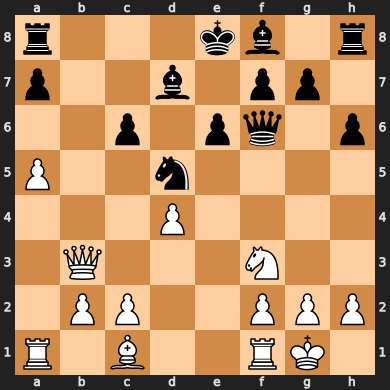

In [ ]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_tensor(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.84      0.78      0.81     85601
           1       0.64      0.64      0.64     85601
           2       0.61      0.64      0.63     85601
           3       0.65      0.63      0.64     85601
           4       0.63      0.67      0.65     85601
           5       0.63      0.66      0.65     85601
           6       0.83      0.79      0.81     85601

    accuracy                           0.69    599207
   macro avg       0.69      0.69      0.69    599207
weighted avg       0.69      0.69      0.69    599207



In [ ]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [ ]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [ ]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(TRAIN_PATH),
    "val":   str(VAL_PATH),
    "test":  str(TEST_PATH)
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/seresnet/run_2026_01_10_seresnet_config.json
[Logs] Saved training history to experiments/logs/seresnet/run_2026_01_10_seresnet_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        68.58%
[Results] Off-by-1 Acc:    93.64%
[Results] MAE:             0.4134
[Results] Latency:         0.0395 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 9766 samples
   - Off by 4: 2472 samples
   - Off by 5: 1372 samples
   - Off by 6: 571 samples
[Results] Saved all metrics to experiments/results/seresnet
------------------------------------------------------------


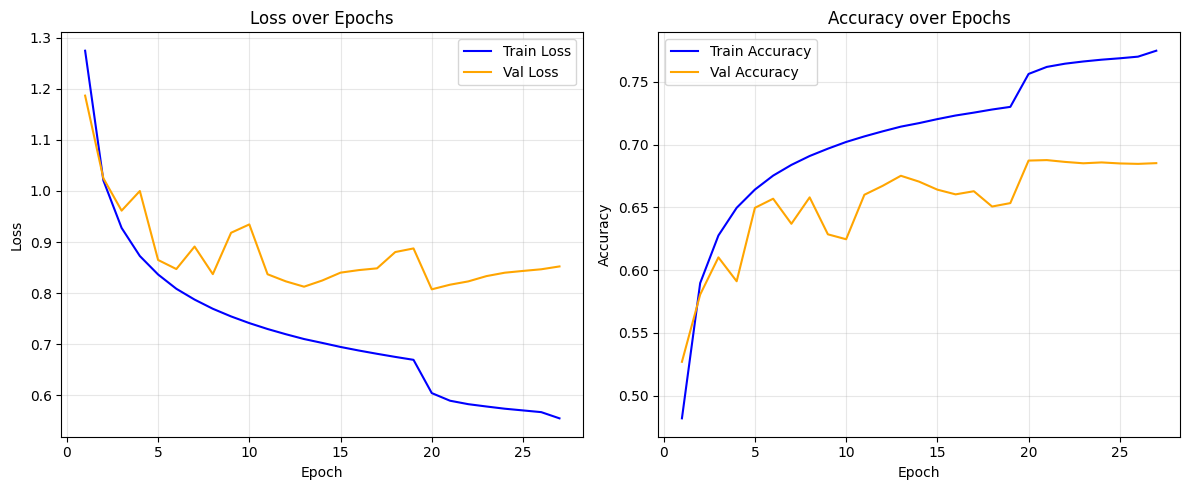

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()